# Notebook to reproduce spectral figures

In [1]:
# return figures in svg
%config InlineBackend.figure_formats = ['png']

import h5py
import bayesprev
import numpy as np
import pandas as pd
from itertools import product, combinations
from os.path import join as pjoin

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
# some helper functions

def jn(mlist, char=None):
    if not char:
        char = '_'
    string = char.join(mlist)
    return string


def flatten(nested):
    flatl = [item for sublist in nested for item in sublist]
    empty_l = [np.asarray(flatl).shape[i]
               for i in range(np.asarray(flatl).ndim)]
    tup = tuple(empty_l)
    flat_list = np.array(flatl).reshape(tup)
    return flat_list


def split_hemis(chlist):
    left_names, right_names = [], []
    left_index, right_index = [], []
    for i, ch in enumerate(chlist):
        if "'" in ch:
            left_names.append(ch)
            left_index.append(i)
        else:
            right_names.append(ch)
            right_index.append(i)
    return (left_names, right_names, left_index, right_index)

In [3]:
d = {}
b_d = {}

In [4]:
alpha = .01
minimum = 1
abc = 'ABCDEF'
analysis = 'spectral'
sounds = ('speech', 'music', )
bases = ('bapa', 'tones', )
selects = ('speech', 'music', 'shared', )[::-1]

In [5]:
hemis = ['left', 'right']
orientations = ['left', 'right', 'top', 'front']

# all bands
bands = ['delta', 'theta', 'alpha', 'beta', 'lga', 'hfa']
bands_r = ((1, 4), (5, 8), (8, 12), (18, 30), (30, 50), (80, 120))

In [6]:
color = {
    'speech': [  # red
        np.array((242, 152, 154)).reshape(1, -1),
        np.array((254, 75, 73)).reshape(1, -1),
    ],
    'music': [  # blue
        np.array((148, 210, 221)).reshape(1, -1),
        np.array((43, 183, 200)).reshape(1, -1),
    ],
    'shared': [  # yellow tones
        np.array((255, 255, 255)).reshape(1, -1),
        np.array((255, 255, 255)).reshape(1, -1),
    ]}

In [7]:
regions = {'Left': {'Frontal': ['IFG, Left Inf', 'MFG, Left Mid', 'OrG, Left Orb', 'PCL, Left Par', 'PrG, Left Pre', 'SFG, Left Sup'],
                    'Temporal': ['FuG, Left Fus', 'ITG, Left Inf', 'MTG, Left Mid', 'PhG, Left Par', 'STG, Left Sup', 'pSTS, Left po'],
                    'Parietal': ['IPL, Left Inf', 'Pcun, Left Pr', 'PoG, Left Pos', 'SPL, Left Sup'], 'Insular': ['INS, Left Ins'],
                    'Subcortical': ['Amyg, Left Am', 'BG, Left Basa', 'Hipp, Left Hi', 'Tha, Left Tha']},
           'Right': {'Frontal': ['IFG, Right In', 'MFG, Right Mi', 'OrG, Right Or', 'PrG, Right Pr', 'SFG, Right Su'],
                     'Temporal': ['FuG, Right Fu', 'ITG, Right In', 'MTG, Right Mi', 'PhG, Right Pa', 'STG, Right Su', 'pSTS, Right p'],
                     'Parietal': ['IPL, Right In', 'Pcun, Right P', 'PoG, Right Po', 'SPL, Right Su'],
                     'Insular': ['INS, Right In'], 'Limbic': ['CG, Right Cin'],
                     'Subcortical': ['Amyg, Right A', 'BG, Right Bas', 'Hipp, Right H', 'Tha, Right Th']}
           }
lobes = ['Frontal', 'Insular', 'Temporal', 'Subcortical', 'Parietal'][::-1]

## Prepare DF

### Load raw data

## Load base DF (with too many channels)

In [8]:
with pd.HDFStore(pjoin('data', 'ispeech_spectral.h5'), mode='r') as store:
    df = store.select('df')
sujs = np.unique(df.subject)
sujs

array(['sub-14c725b6b803', 'sub-26176ef8a8d0', 'sub-28e70e7c7fbb',
       'sub-3ef8645f99c5', 'sub-4247d6d6cdbf', 'sub-44375d501493',
       'sub-45a6830d263e', 'sub-82e330f8aadd', 'sub-83ebd5328120',
       'sub-95a634be7e05', 'sub-9d783b836f5e', 'sub-a4e7fc9daa96',
       'sub-c1b7ce54ce05', 'sub-c2a96116ddc4', 'sub-cacae171ee15',
       'sub-e0bb6ccef2a5', 'sub-ebf231d97f73', 'sub-fccb4adbfadc'],
      dtype=object)

In [9]:
df.head()

subject    chnames  \
0  sub-9d783b836f5e  TB7-TB8_a   
2  sub-9d783b836f5e    A3-A4_a   
3  sub-9d783b836f5e    A4-A5_a   
4  sub-9d783b836f5e    A5-A6_a   
5  sub-9d783b836f5e    A6-A7_a   

                                         brainnetome      left_x      left_y  \
0  ITG, Right Inferior Temporal Gyrus A20cv, caud...  392.926388  553.686085   
2       Amyg, Right Amygdala lAmyg, lateral amygdala  350.224935  511.700626   
3       Amyg, Right Amygdala lAmyg, lateral amygdala  350.782792  512.120587   
4       Amyg, Right Amygdala lAmyg, lateral amygdala  351.802839  512.610182   
5  STG, Right Superior Temporal Gyrus A38l, later...  352.959321  512.934873   

      right_x     right_y       top_x       top_y     front_x  ...  \
0  409.323208  609.558930  569.535890  370.953811  205.343974  ...   
2  457.164266  531.548735  488.508381  329.681439  298.702519  ...   
3  457.727643  535.312162  501.811798  329.812124  283.344638  ...   
4  458.587468  541.629340  524.254727  330.125815  257.388868  ...   
5  459.278657  548.039173  546.731251  330.600308  231.347318  ...   

   neg_bapa_speech_preferred_hfa  neg_bapa_music_preferred_hfa  \
0                            NaN                           NaN   
2                            NaN                           NaN   
3                            NaN                           NaN   
4                            NaN                           NaN   
5                            NaN                           NaN   

  neg_bapa_speech_selective_hfa neg_bapa_music_selective_hfa  \
0                           NaN                          NaN   
2                           NaN                          NaN   
3                           NaN                          NaN   
4                           NaN                          NaN   
5                           NaN                          NaN   

  music_difference_speech_delta_T0 music_difference_speech_theta_T0  \
0                       -10.754776                        -3.612561   
2                       -11.053524                        -1.305579   
3                         0.198417                        -0.899897   
4                        -4.822852                        -1.753562   
5                        -9.499389                        -6.785942   

  music_difference_speech_alpha_T0 music_difference_speech_beta_T0  \
0                         1.672415                        3.808892   
2                        -1.237575                        1.073940   
3                        -1.885586                        0.127610   
4                        -1.473254                       -0.281025   
5                        -0.903990                        1.525058   

   music_difference_speech_lga_T0  music_difference_speech_hfa_T0  
0                        3.116959                        1.234146  
2                        5.754976                        0.874208  
3                        0.287981                        0.354691  
4                        0.277177                        0.550055  
5                        0.658337                       -0.646615  

[5 rows x 264 columns]

## Functions for figures

Some **plotting prefixes**

In [10]:
# fontsizes
fticks = 27
flabels = 35
fcount = 52
lwidth = 2  # line width
size = .3  # pie sizes

# filters to loop over
visuals = ['shared', 'preferred', 'selective']
bars = categories = ['shared', 'speech_preferred', 'music_preferred',
                     'speech_selective', 'music_selective']

emdash = u'\u2014'
hatchp = 'x'

outer_colors = [np.array((255, 255, 255)).reshape(1, -1) / 255,
                np.array((52, 52, 53)).reshape(1, -1) / 255,
                'grey']
inner_colors = [color['shared'][1] / 255] + [color[sound]
                                             [1] / 255 for i, sound in product(range(2)[::-1], sounds[:2])]

matplotlib.rcParams['hatch.linewidth'] = 2.0
brains = hemis

# font settings
fpath = '/Library/Fonts'
font = 'Regular'
prop = fm.FontProperties(fname=pjoin(
    fpath, 'SF-Pro-Text-%s.otf' % font), size=flabels)

### Nested pies and brain figures

In [33]:
def main_figure(base, sign):
    fig3 = plt.figure(figsize=(27, 37),
                      constrained_layout=False, facecolor=None, alpha=0)

    # prepare legend
    ###########################################################################################
    gs = fig3.add_gridspec(top=1.25)
    axes = fig3.add_subplot(gs[0, :])

    # legend patches
    sounds_l = [mpatches.Patch(facecolor=color[sound][1] /
                               255, label=sound, edgecolor='k', linewidth=lwidth) for sound in sounds[:2]]
    category_l = [mpatches.Patch(facecolor=outer_colors[i], edgecolor='k', label=cat)
                  for i, cat in enumerate(visuals)]
    axes.legend(handles=sounds_l + category_l,
                ncol=6,
                loc='upper right',
                prop=prop,
                labelspacing=.7,
                frameon=False)
    axes.set_axis_off()

    for z, band in enumerate(bands):
        gs = fig3.add_gridspec(2, 2,
                               wspace=.1,
                               hspace=-.3,
                               left=0 if z < 3 else .55,
                               right=.45 if z < 3 else 1,
                               bottom=(3 - z % 3) * .3,
                               top=((3 - z % 3) + 1) * .3)

        band_name = 'HFa' if band == 'hfa' else 'low gamma' if band == 'lga' else band

        # Brain figure
        ##############################################################################
        for o, orientation in enumerate(brains):

            # which axes
            axes = fig3.add_subplot(gs[1, o])

            # collect stored mayavi brain images
            with h5py.File(pjoin('data', 'bg_img.hdf5'), 'r') as hf:
                im = hf[orientation][...]
            axes.imshow(im)

            for v, viz in enumerate(visuals):
                if viz == 'preferred':
                    continue
                for j in range(20):
                    for sound in sounds[:2]:
                        if viz != 'shared':
                            label = jn([sign, base, sound, viz, band])
                        else:
                            if sound == 'music':
                                continue
                            label = jn([sign, base, viz, band])

                        # filter dataframe and move on if nothing matches
                        t_df = df.loc[~(df[label].isna())]

                        temp_df = t_df.loc[(t_df['chorder'] == str(j))]
                        if len(temp_df) == 0:
                            continue

                        # collect coordinates
                        df_x = temp_df[jn([orientation, 'x'])].values
                        df_y = temp_df[jn([orientation, 'y'])].values
                        _, _, left_i, right_i = split_hemis(
                            chlist=temp_df['chnames'].values)
                        if orientation in hemis:
                            x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
                            y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
                        else:
                            x_h = df_x
                            y_h = df_y

                        # plot elecs scatterplot
                        axes.scatter(x_h,
                                     y_h,
                                     edgecolors='k',
                                     color=outer_colors[v] if 'selective' not in viz else color[label.split('_')[
                                         2]][1] / 255,
                                     label='%s %s' % (len(x_h), label),
                                     s=120 * np.ones(len(x_h)),
                                     marker="o",
                                     linewidth=lwidth)

                    # clean up subplot
                    axes.set_axis_off()

        # Band title figure
        ##############################################################################
        band_title = fig3.add_subplot(gs[0, 0])
        axes = band_title
        axes.set_title(abc[z].upper(), fontsize=fcount, loc='left', y=0.7)
        axes.text(.5,
                  .5,
                  '%s %s\n(%s %s %s Hz)' % (
                      band_name,
                      'band' if band != 'hfa' else '',
                      bands_r[z][0],
                      emdash,
                      bands_r[z][1]),
                  fontsize=fcount-10,
                  ha='center', va='center')
        # clean up subplot
        axes.set_axis_off()

        # Nested pie figure
        ##############################################################################
        axes = fig3.add_subplot(gs[0, 1])
        # Turn off axes and set axes limits

        # prepare counts per category for the rings
        inner_len = [len(df.loc[~(df[jn([sign, base, bar, band])].isna())])
                     for bar in bars]
        outer_len = [len(df.loc[~(df[jn([sign, base, 'shared', band])].isna())])] + [
            len(df.loc[~(df[jn([sign, base, 'speech', viz, band])].isna())]) + len(df.loc[~(df[jn([sign, base, 'music', viz, band])].isna())]) for viz in visuals[1:]]

        # sum of significant electrodes
        all_sum = np.array([len(df.loc[~(df[jn([sign, base, bar, band])].isna())])
                           for bar in bars]).sum()

        # percentage significant electrodes over whole brain
        # in total and per category
        p_overbrain = np.round((all_sum / len(df)) * 100, 1)
        percentages = ['%s%%' % np.round((j / all_sum) * 100, 1)
                       for j in outer_len]

        # plot outer pie
        axes.pie(outer_len,
                 radius=1,
                 colors=outer_colors,
                 labels=percentages,
                 textprops={'fontsize': fticks},
                 wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))

        # inner pie
        inner = axes.pie(inner_len,
                         radius=1 - size,
                         colors=inner_colors,
                         wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))

        # add hatch pattern to preferred
        for h in range(2):
            inner[0][h+1].set_hatch(hatchp)
            inner[0][h+1].set_edgecolor(np.array((52, 52, 53)
                                                 ).reshape(1, -1) / 255)

        axes.text(0., 0.,
                  '%s%%' % (p_overbrain),
                  fontsize=flabels,
                  ha='center',
                  va='center')

    fig3.savefig(pjoin('figures', 'main_%s_%s.svg' %
                 (base, sign)), transparent=True)

### Nested pies per hemi

In [12]:
def hemi_pies(base, sign):
    fig3 = plt.figure(figsize=(27, 37),
                      constrained_layout=False, facecolor=None, alpha=0)

    # prepare legend
    ###########################################################################################
    gs = fig3.add_gridspec(top=1.25)
    axes = fig3.add_subplot(gs[0, :])

    # legend patches
    sounds_l = [mpatches.Patch(facecolor=color[sound][1] /
                               255, label=sound, edgecolor='k', linewidth=lwidth) for sound in sounds[:2]]
    category_l = [mpatches.Patch(facecolor=outer_colors[i], edgecolor='k', label=cat)
                  for i, cat in enumerate(visuals)]
    axes.legend(handles=sounds_l + category_l,
                ncol=6,
                loc='upper right',
                prop=prop,
                labelspacing=.7,
                frameon=False)
    axes.set_axis_off()

    for z, band in enumerate(bands):
        gs = fig3.add_gridspec(2, 2,
                               wspace=.1,
                               hspace=-.3,
                               left=0 if z < 3 else .55,
                               right=.45 if z < 3 else 1,
                               bottom=(3 - z % 3) * .3,
                               top=((3 - z % 3) + 1) * .3)

        band_name = 'HFa' if band == 'hfa' else 'low gamma' if band == 'lga' else band

        # Brain figure
        ##############################################################################
        for o, orientation in enumerate(brains):

            # which axes
            axes = fig3.add_subplot(gs[1, o])

            # collect stored mayavi brain images
            with h5py.File(pjoin('data', 'bg_img.hdf5'), 'r') as hf:
                im = hf[orientation][...]
            axes.imshow(im)

            for v, viz in enumerate(visuals):
                if viz == 'preferred':
                    continue
                for j in range(20):
                    for sound in sounds[:2]:
                        if viz != 'shared':
                            label = jn([sign, base, sound, viz, band])
                        else:
                            if sound == 'music':
                                continue
                            label = jn([sign, base, viz, band])

                        # filter dataframe and move on if nothing matches
                        t_df = df.loc[~(df[label].isna())]

                        temp_df = t_df.loc[(t_df['chorder'] == str(j))]
                        if len(temp_df) == 0:
                            continue

                        # collect coordinates
                        df_x = temp_df[jn([orientation, 'x'])].values
                        df_y = temp_df[jn([orientation, 'y'])].values
                        _, _, left_i, right_i = split_hemis(
                            chlist=temp_df['chnames'].values)
                        if orientation in hemis:
                            x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
                            y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
                        else:
                            x_h = df_x
                            y_h = df_y

                        # plot elecs scatterplot
                        axes.scatter(x_h,
                                     y_h,
                                     edgecolors='k',
                                     color=outer_colors[v] if 'selective' not in viz else color[label.split('_')[
                                         2]][1] / 255,
                                     label='%s %s' % (len(x_h), label),
                                     s=120 * np.ones(len(x_h)),
                                     marker="o",
                                     linewidth=lwidth)

                    # clean up subplot
                    axes.set_axis_off()

            # Nested pie figure
            ##############################################################################
            axes = fig3.add_subplot(gs[0, o])
            # Turn off axes and set axes limits
            # tdf = df.loc[(df['brainnetome'].str.contains(orientation.capitalize()))]
            if orientation == 'left':
                tdf = df.loc[(df['chnames'].str.contains("'"))]
            else:
                tdf = df.loc[~(df['chnames'].str.contains("'"))]

            # prepare counts per category for the rings
            inner_len = [len(tdf.loc[~(df[jn([sign, base, bar, band])].isna())])
                         for bar in bars]
            outer_len = [len(tdf.loc[~(df[jn([sign, base, 'shared', band])].isna())])] + [
                len(tdf.loc[~(tdf[jn([sign, base, 'speech', viz, band])].isna())]) + len(tdf.loc[~(tdf[jn([sign, base, 'music', viz, band])].isna())]) for viz in visuals[1:]]

            # sum of significant electrodes
            all_sum = np.array([len(tdf.loc[~(tdf[jn([sign, base, bar, band])].isna())])
                               for bar in bars]).sum()

            # percentage significant electrodes over whole brain
            # in total and per category
            p_overbrain = np.round((all_sum / len(tdf)) * 100, 1)
            percentages = ['%s%%' % np.round((j / all_sum) * 100, 1)
                           for j in outer_len]

            # plot outer pie
            eerste, texts = axes.pie(outer_len,
                                     radius=1,
                                     colors=outer_colors,
                                     labels=percentages,
                                     textprops={'fontsize': fticks},
                                     wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))
            plt.setp(texts, fontsize=25)  # update

            # inner pie
            inner = axes.pie(inner_len,
                             radius=1 - size,
                             colors=inner_colors,
                             wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))

            # add hatch pattern to preferred
            for h in range(2):
                inner[0][h+1].set_hatch(hatchp)
                inner[0][h+1].set_edgecolor(np.array((52, 52, 53)
                                                     ).reshape(1, -1) / 255)

            axes.text(0., 0.,
                      '%s%%' % (p_overbrain),
                      fontsize=flabels,
                      ha='center',
                      va='center')

        # Band title figure
        ##############################################################################
        band_title = fig3.add_subplot(gs[0, 0])
        axes = band_title
        axes.set_title(abc[z].upper(), fontsize=fcount, loc='left', y=1)
        axes.text(1,
                  1,
                  '%s %s (%s %s %s Hz)' % (
                      band_name,
                      'band' if band != 'hfa' else '',
                      bands_r[z][0],
                      emdash,
                      bands_r[z][1]),
                  fontsize=fcount-10,
                  ha='center', va='center')
        # clean up subplot
        axes.set_axis_off()

    fig3.savefig(pjoin('figures', 'hemis_%s_%s.svg' %
                 (base, sign)), transparent=True)

### Prevalence figures

In [51]:
def prevalence_figure(base, sign, category='selective'):

    fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharey=True)

    for b, band in enumerate(bands[:]):
        axes = ax[b % 3, int(b/3)]
        columns = ['%s_difference_%s_%s_sign' %
                   (base, sound, band) for sound in ('speech', 'music', )]
        s_df = df  # .loc[(df[columns].notnull().any(axis=1))]
        counter = 0
        ylabels = []
        yticks = []
        for hem, lobe in product(('Left', 'Right', ), lobes):
            counter += 1
            for j, r in enumerate(regions[hem][lobe]):
                d[jn([band, hem, lobe, r, sign])] = []
                total_s = 0
                for select in selects:
                    b_d[select] = 0
                temp = s_df.loc[(s_df['brainnetome']).str.startswith(r)]
                nrsujs = len(set(temp['subject']))
                nrelecs = len(df.loc[(df['brainnetome']).str.startswith(r)])
                for subject in set(temp['subject']):
                    t = temp.loc[(temp['subject'] == subject)]
                    if len(t) > minimum:
                        if len(t['%s_%s_shared_%s' % (sign, base, band)].dropna()):
                            total_s += 1
                            b_d['shared'] += 1
                        else:
                            spmu = [len(t['%s_%s_%s_%s_%s' % (
                                sign, base, sound, category, band)].dropna()) for sound in ('speech', 'music', )]
                            if all(spmu):
                                print(band, r, 'ik kom hier')
                                total_s += 1
                                b_d['shared'] += 1
                            elif any(spmu):
                                d[jn([band, hem, lobe, r, sign])].append(subject)
                                if spmu[0]:
                                    total_s += 1
                                    b_d['speech'] += 1
                                else:
                                    total_s += 1
                                    b_d['music'] += 1
                if total_s > minimum:
                    counter += .5
                    for c, k in enumerate(selects):
                        xmap = bayesprev.map(b_d[k], total_s, alpha)
                        if xmap == 0:
                            continue
                        else:
                            # print("%s/%s=%s" % (b_d[k], total_s, xmap))
                            pass
                        label = jn(r.split(' ')[:2], ' ')
                        if label not in ylabels:
                            ylabels.append(jn(r.split(' ')[:2], ' '))
                            yticks.append(counter)
                        perc = (b_d[k]/total_s) * 100
                        axes.plot([counter + (c/10), counter + (c/10)],
                                  [0, perc],
                                  linewidth=1,
                                  zorder=1,
                                  color='grey')
                        axes.scatter(counter + (c/10),
                                     perc, s=b_d[k]*60,
                                     facecolor=np.append(
                                         (color[k][1] / 255), 1),
                                     linewidth=.5,
                                     edgecolor='k',
                                     label=b_d[k],
                                     zorder=2,
                                     alpha=1)
        if band == 'hfa':
            band = 'HFa'
        elif band == 'lga':
            band = 'low gamma'

        axes.set_title('%s. %s %s' % (
            abc[b], band, 'band' if band != 'HFa' else ''), fontsize=21)
        axes.set_xticks(yticks)
        axes.set_xticklabels(ylabels, rotation=90, fontsize=11)
        axes.xaxis.grid(False)
        axes.yaxis.grid(False)
        axes.set_ylim([0, 120])
        if b < 3:
            axes.set_ylabel(
                '% of patients\nover all patients\nexplored within region')

    fig.tight_layout()
    fig.savefig(pjoin('figures', 'prevalence_%s_%s_%s.svg' %
                      (base, sign, category)), transparent=True)

## Base: tones

In [52]:
base = 'tones'

### Sign: pos

In [53]:
sign = 'pos'

#### Grid: **Electrodes distribution** (MNI) and **overview categories** (nested pies) per band

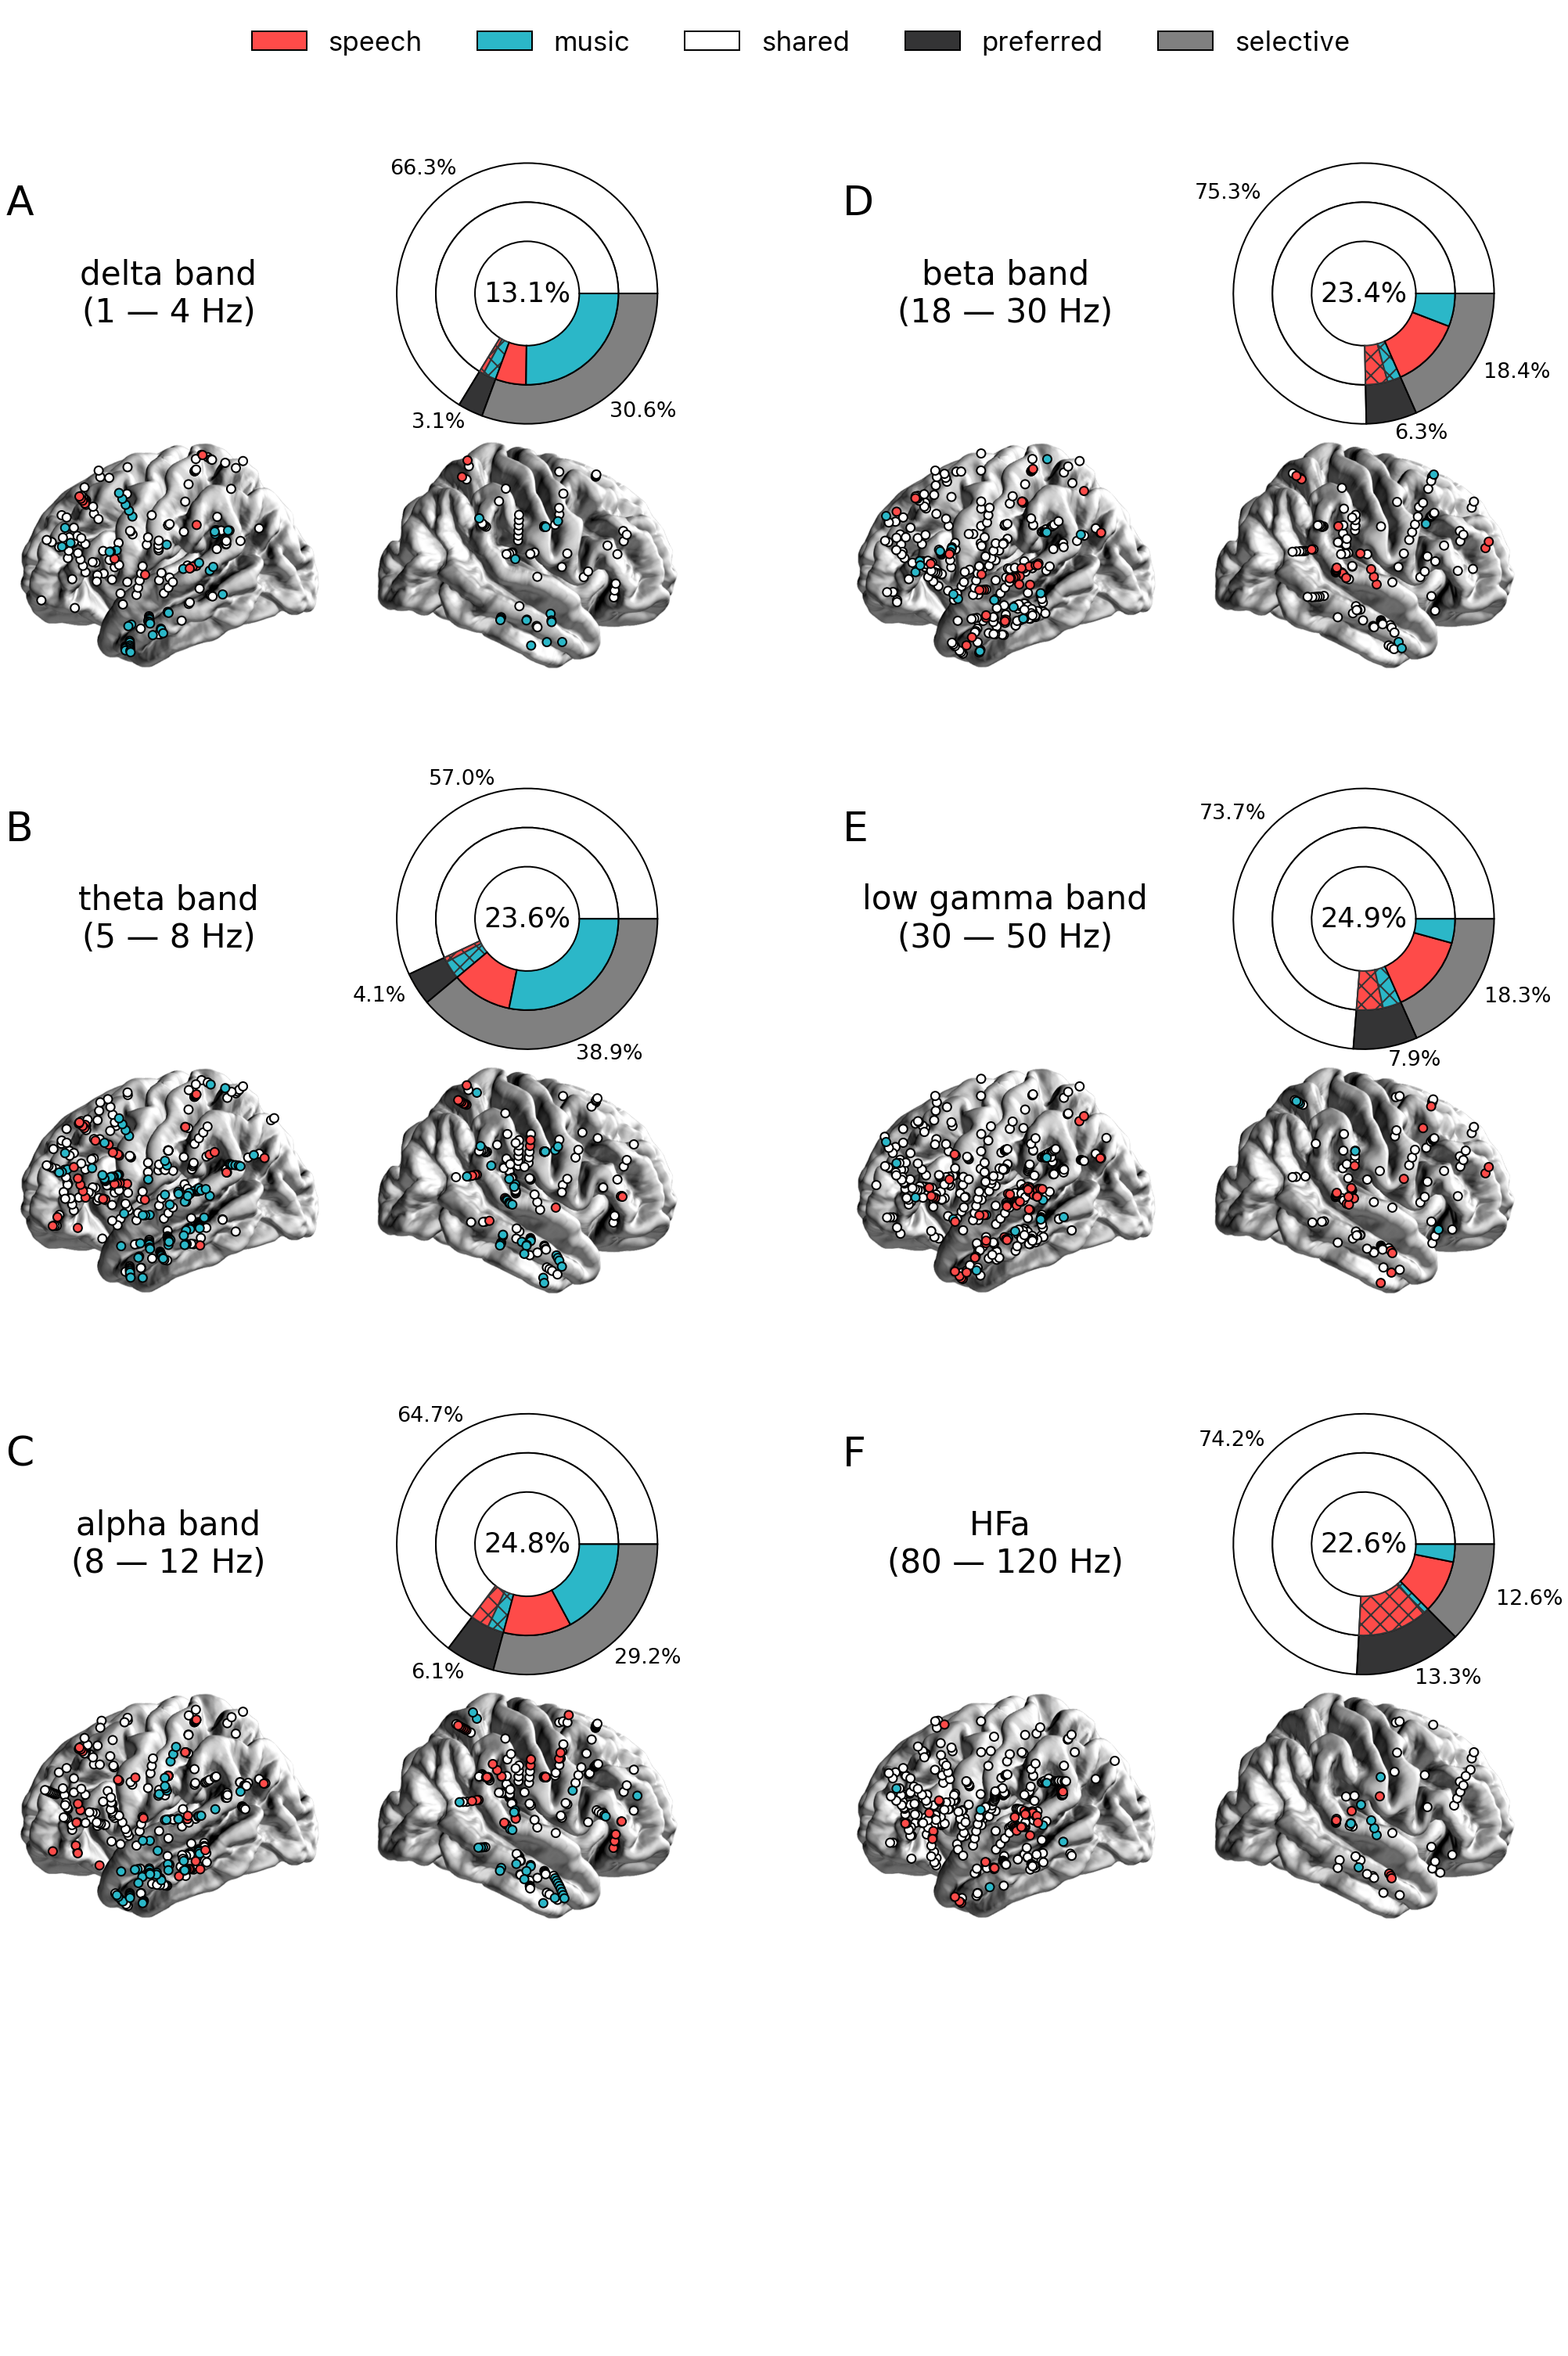

In [54]:
main_figure(base=base, sign=sign)

#### Prevalence

theta Tha, Right Th ik kom hier
lga INS, Left Ins ik kom hier


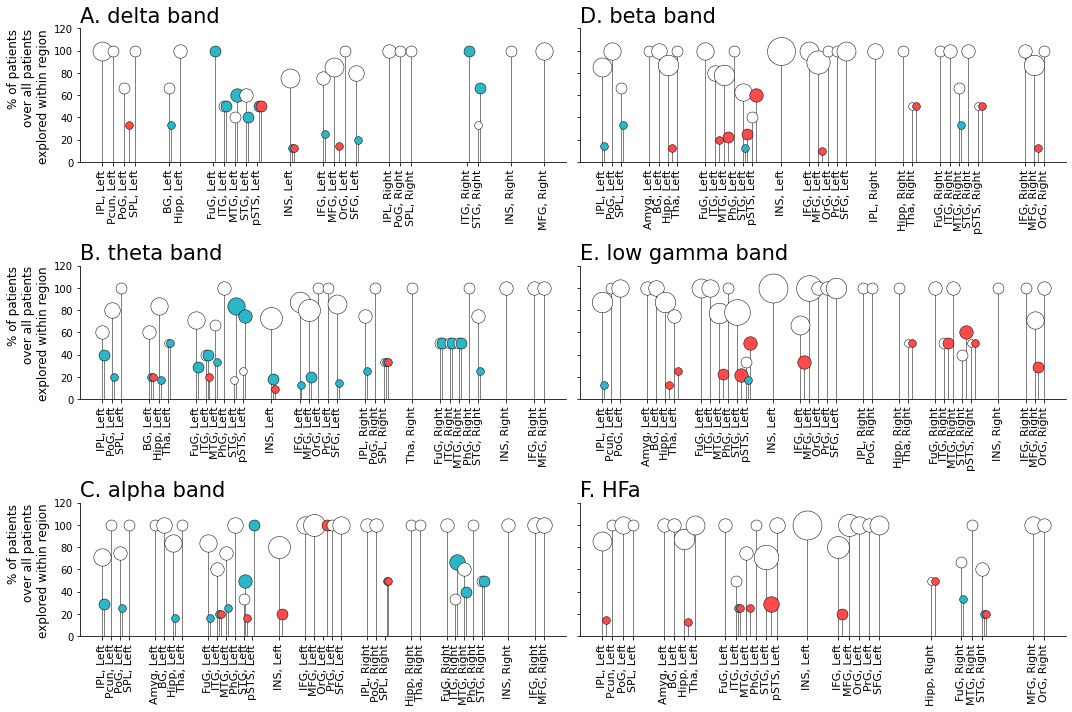

In [55]:
prevalence_figure(base=base, sign=sign)

### Sign: neg

In [56]:
sign = 'neg'

#### Grid: **Electrodes distribution** (MNI) and **overview categories** (nested pies) per band

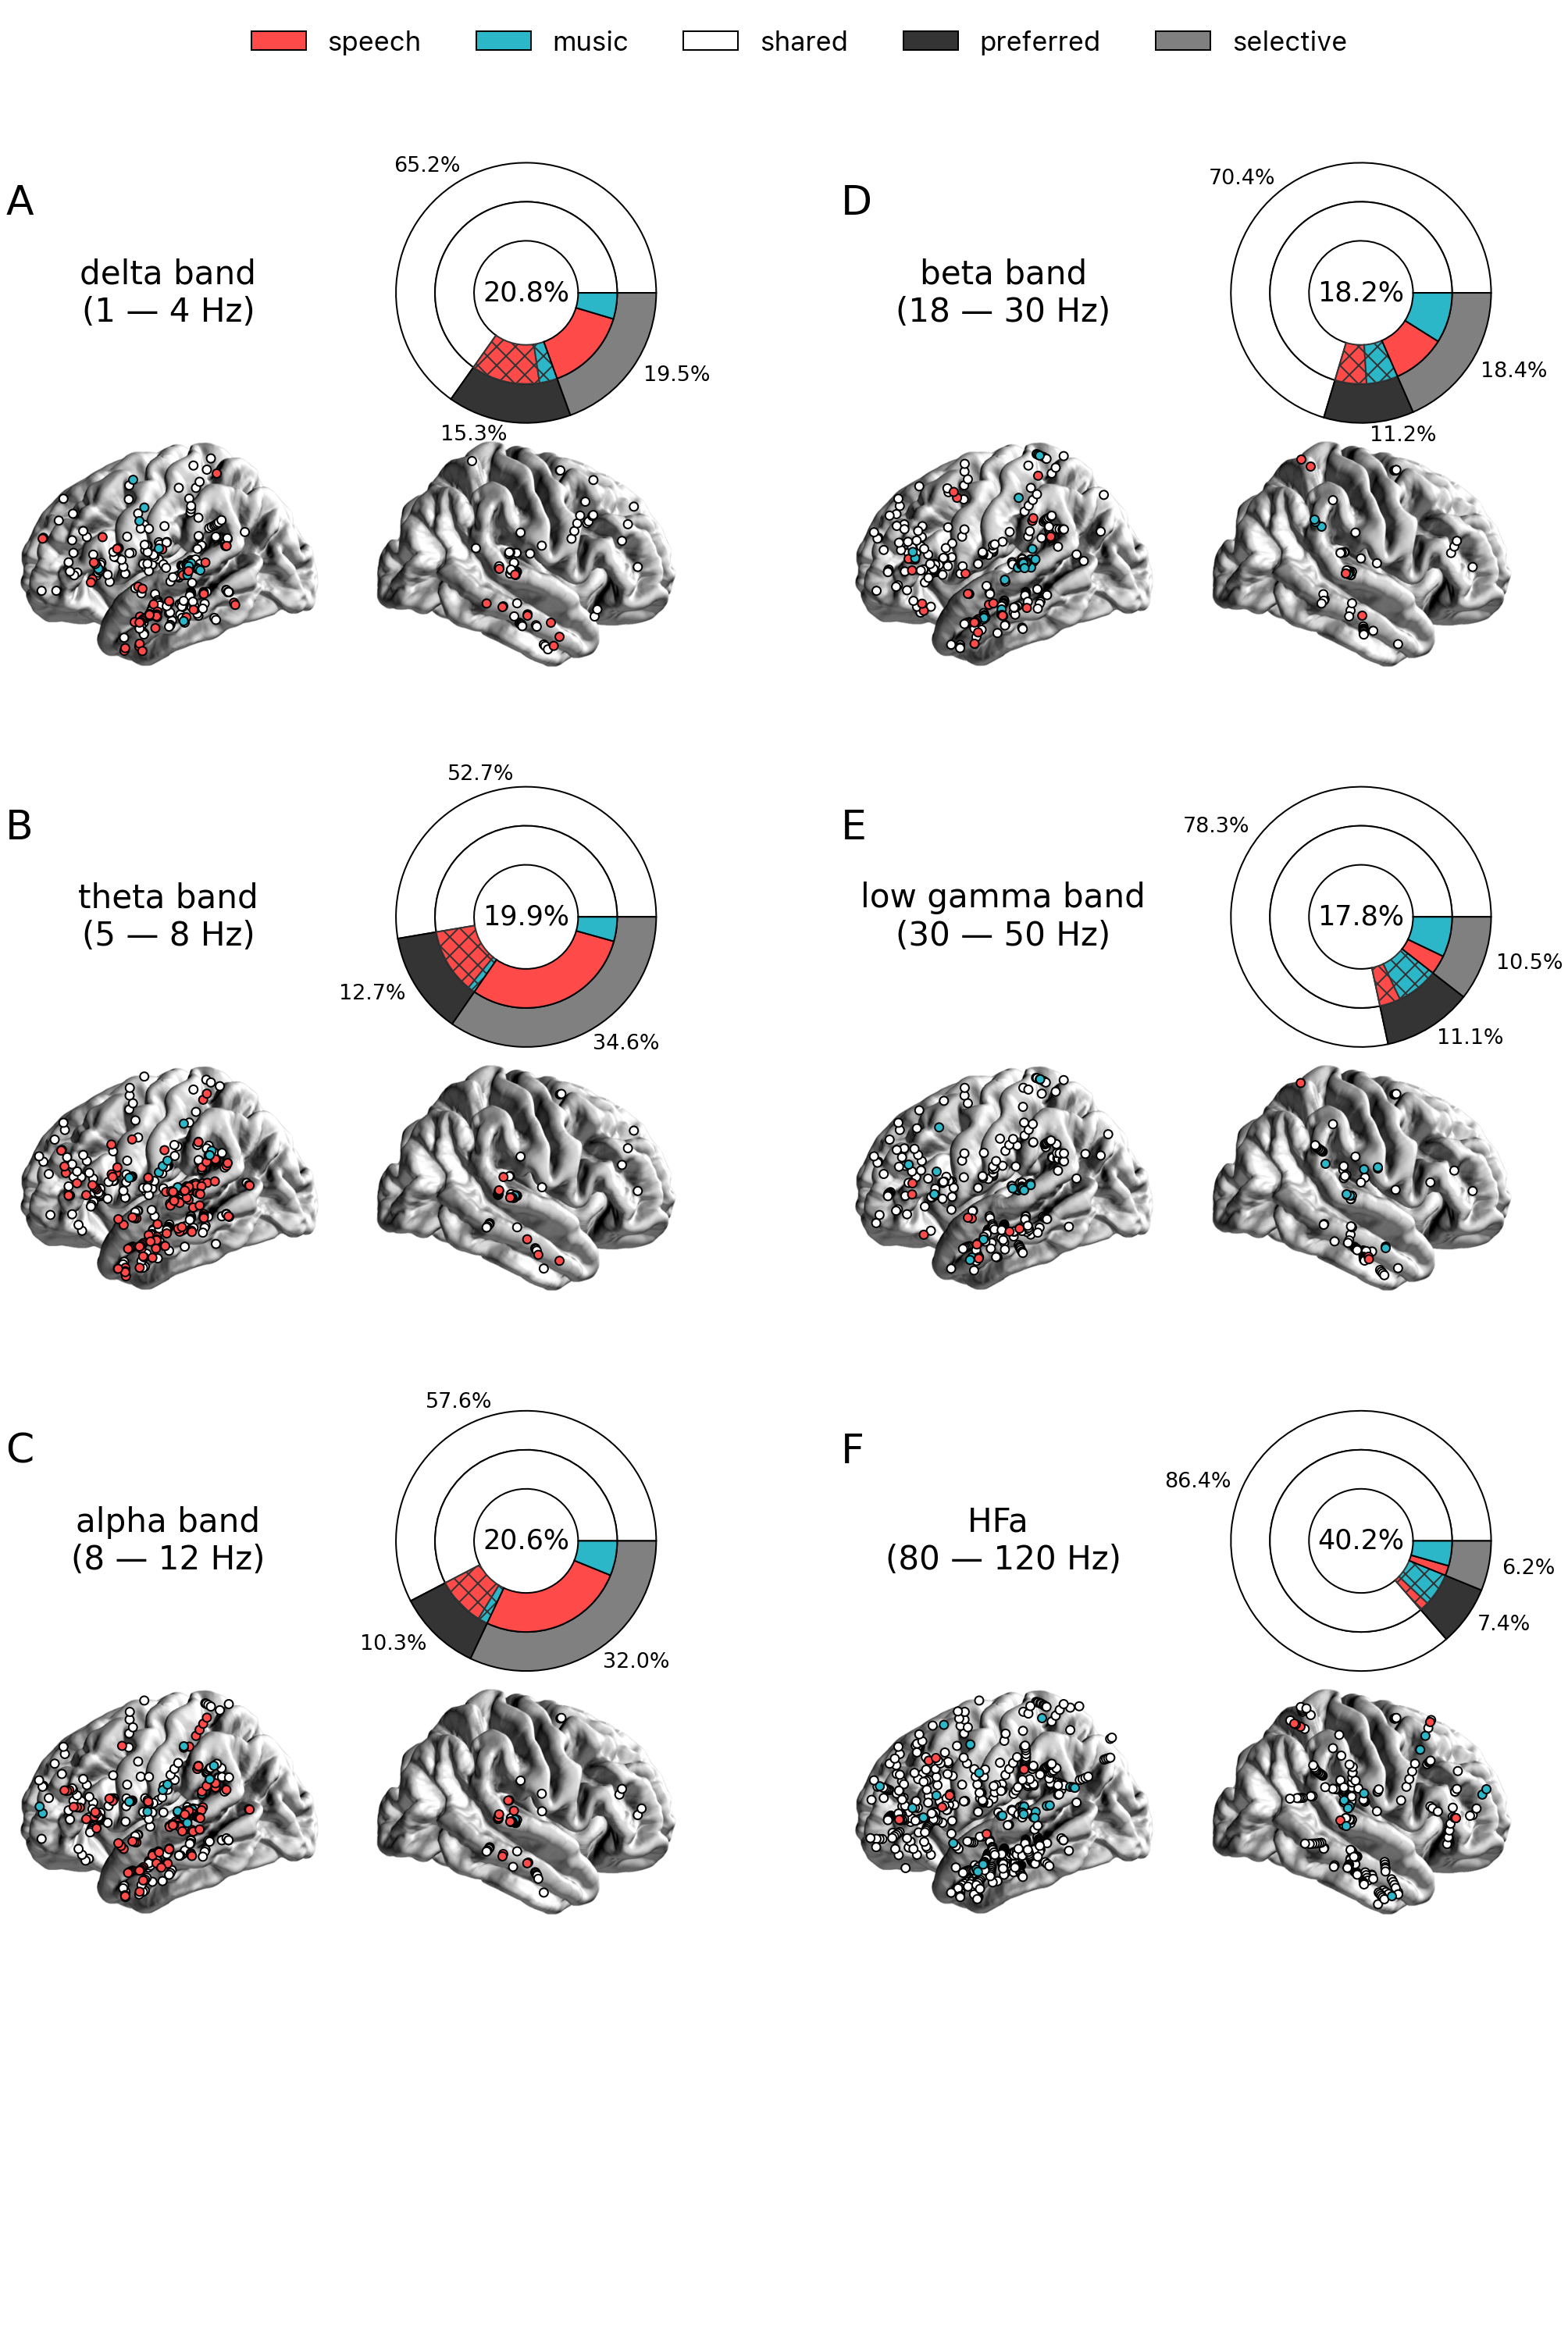

In [57]:
main_figure(base=base, sign=sign)

#### Prevalence

theta STG, Left Sup ik kom hier
beta STG, Left Sup ik kom hier


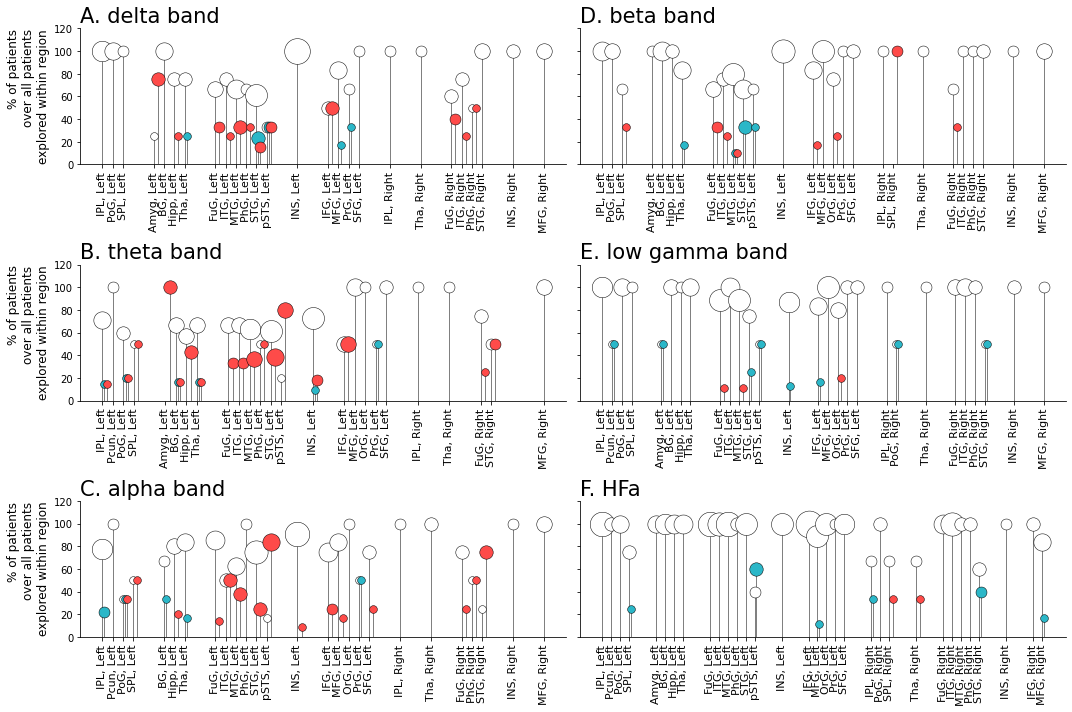

In [58]:
prevalence_figure(base=base, sign=sign)

## Base: bapa

In [59]:
base = 'bapa'

### Sign: pos

In [60]:
sign = 'pos'

#### Grid: **Electrodes distribution** (MNI) and **overview categories** (nested pies) per band

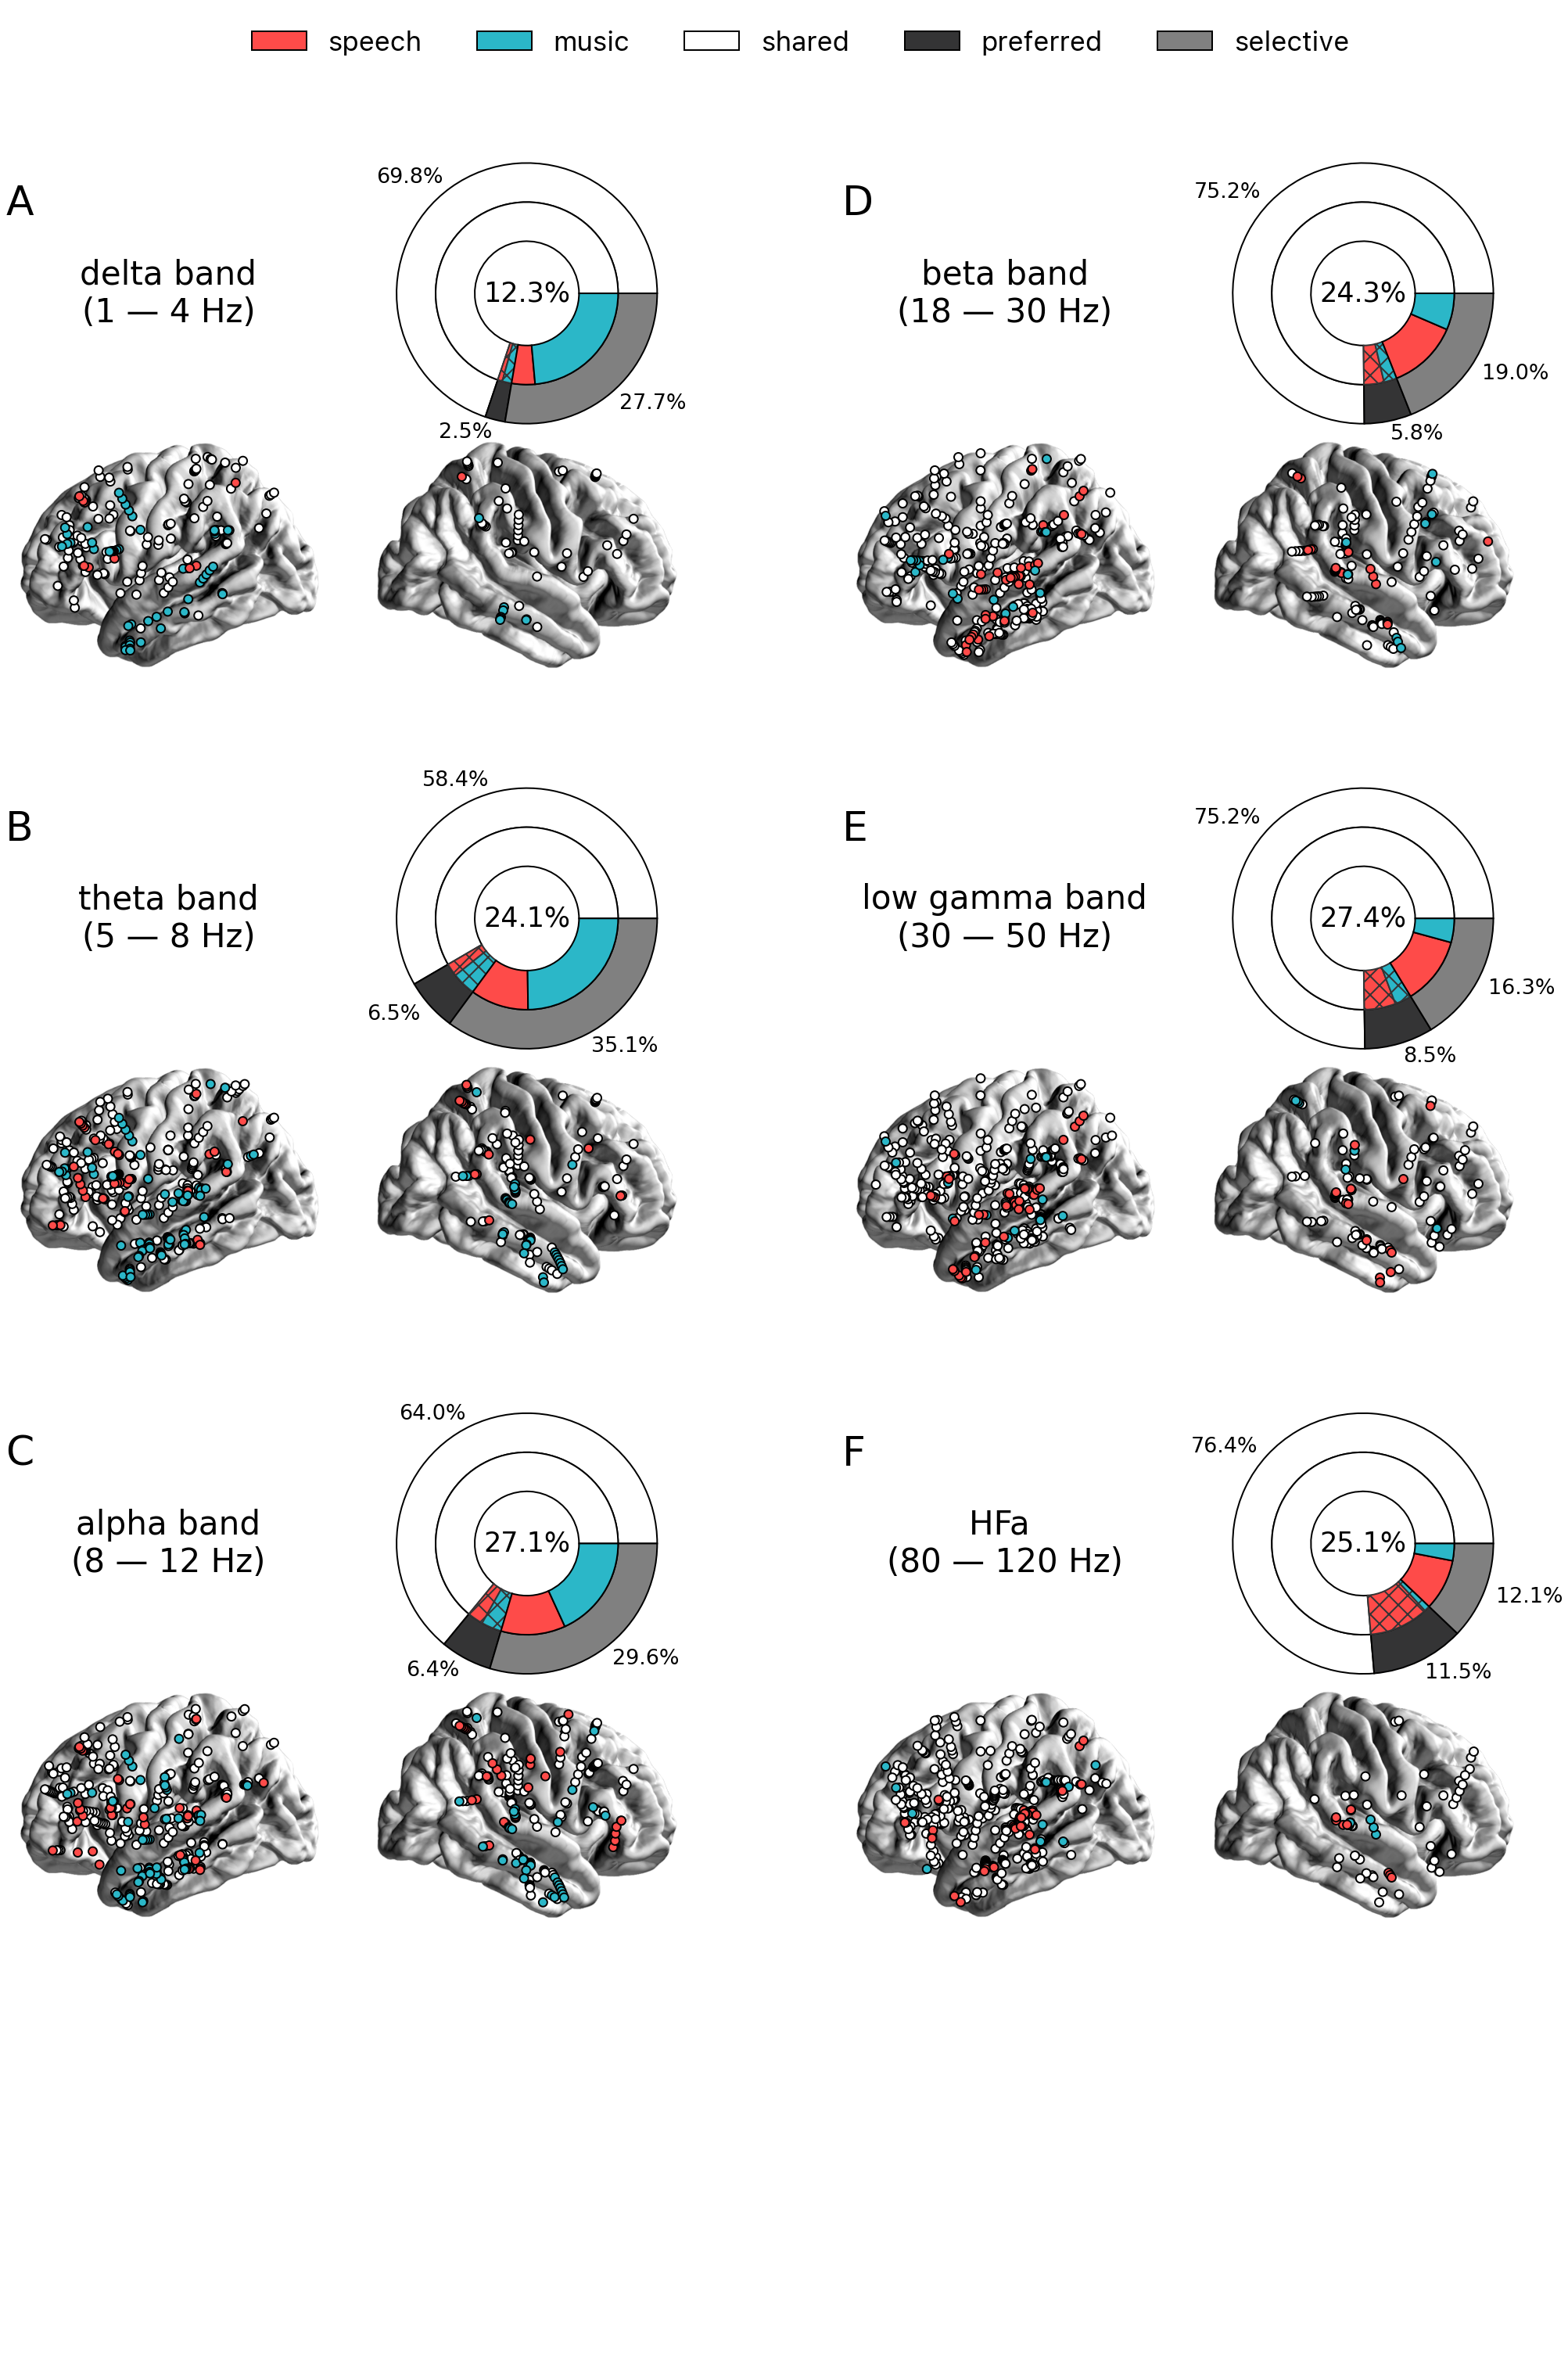

In [61]:
main_figure(base=base, sign=sign)

#### Prevalence

lga INS, Left Ins ik kom hier


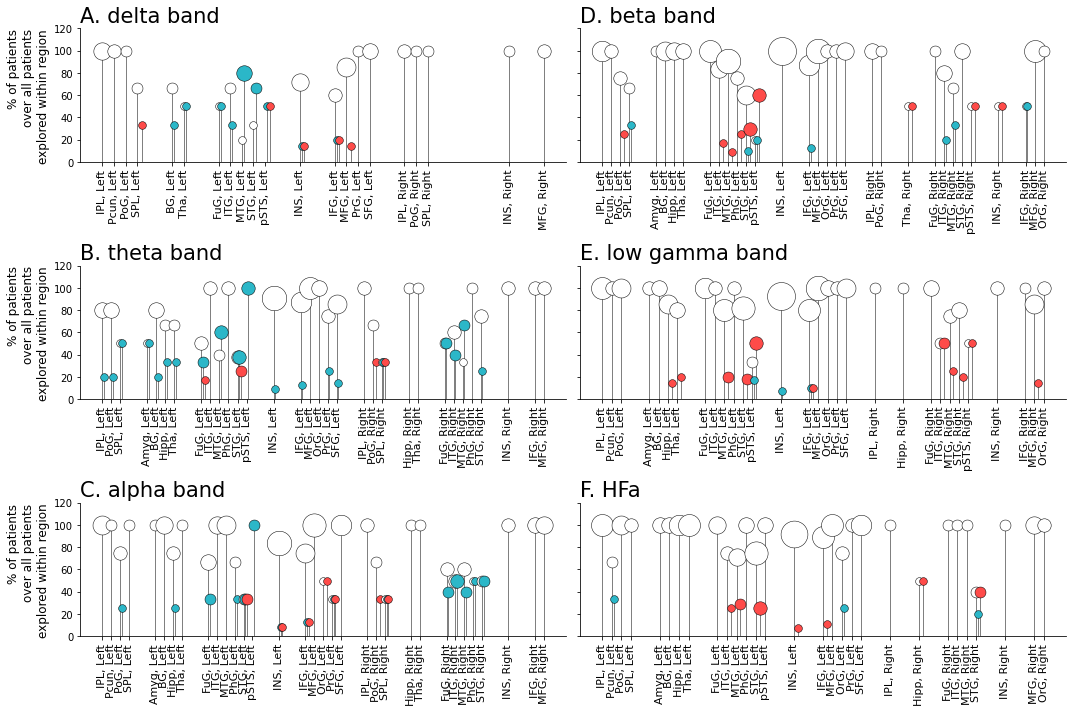

In [62]:
prevalence_figure(base=base, sign=sign)

### Sign: neg

In [63]:
sign = 'neg'

#### Grid: **Electrodes distribution** (MNI) and **overview categories** (nested pies) per band

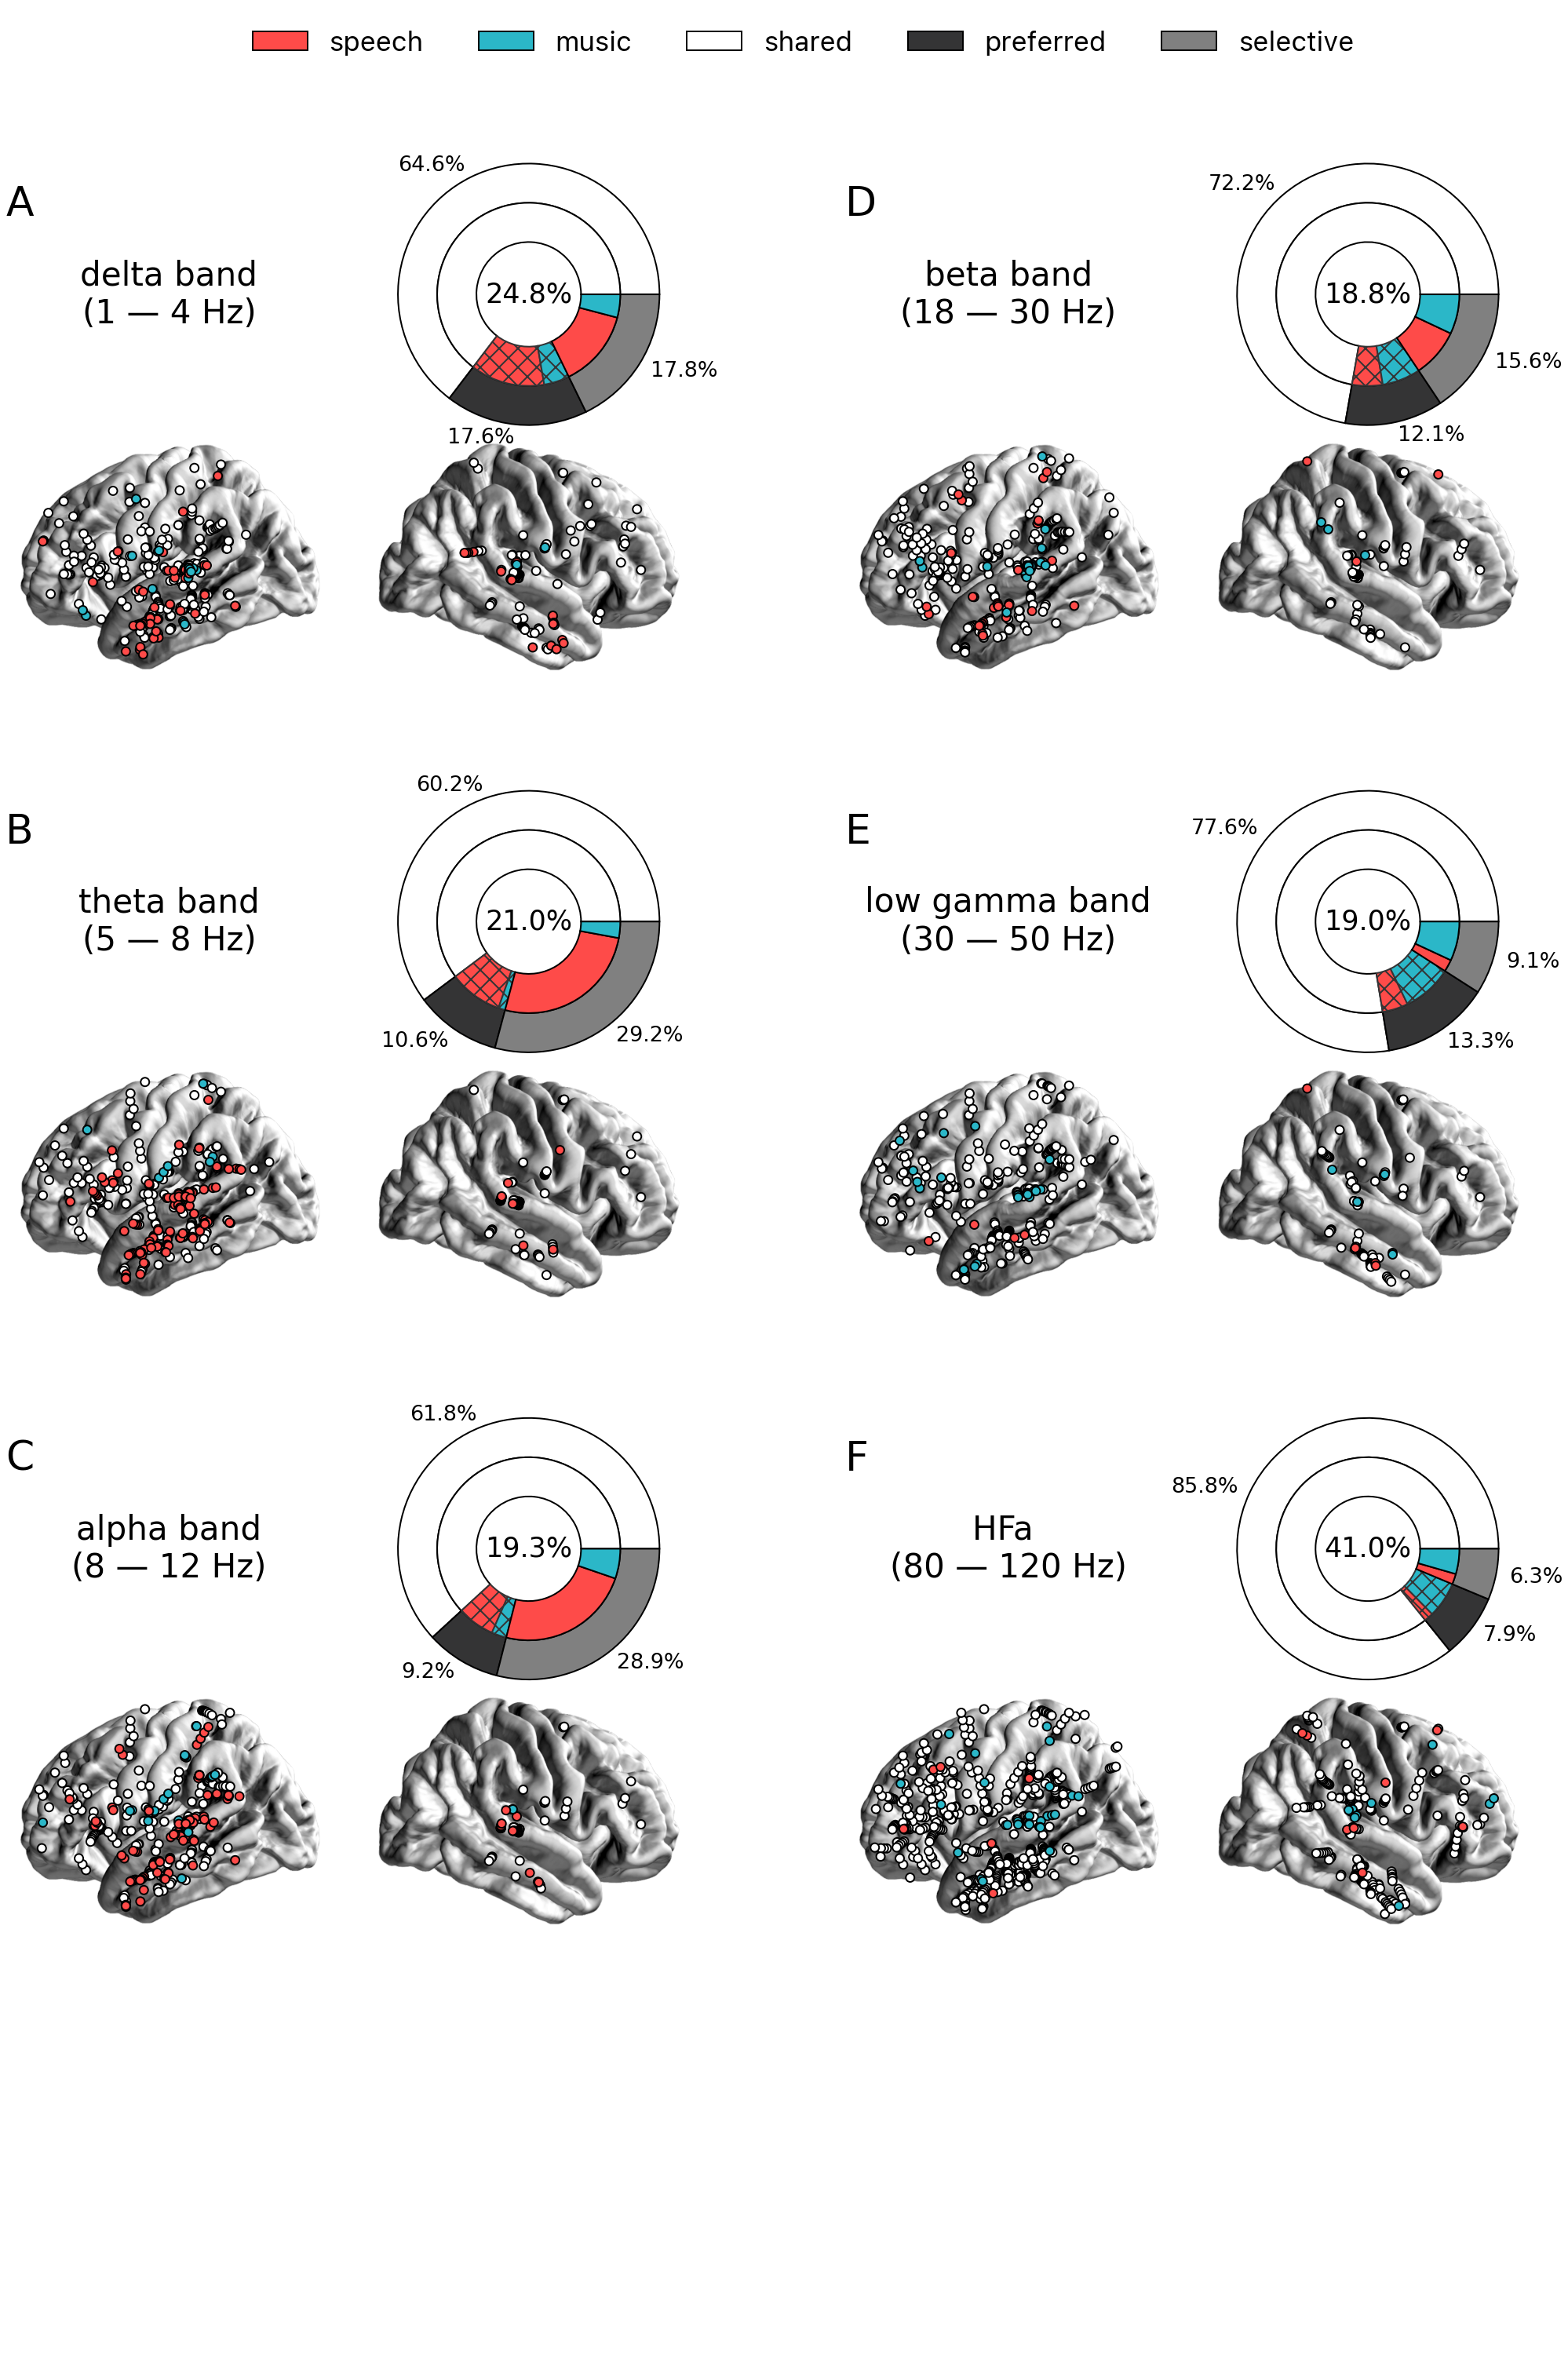

In [64]:
main_figure(base=base, sign=sign)

#### Prevalence

theta STG, Left Sup ik kom hier


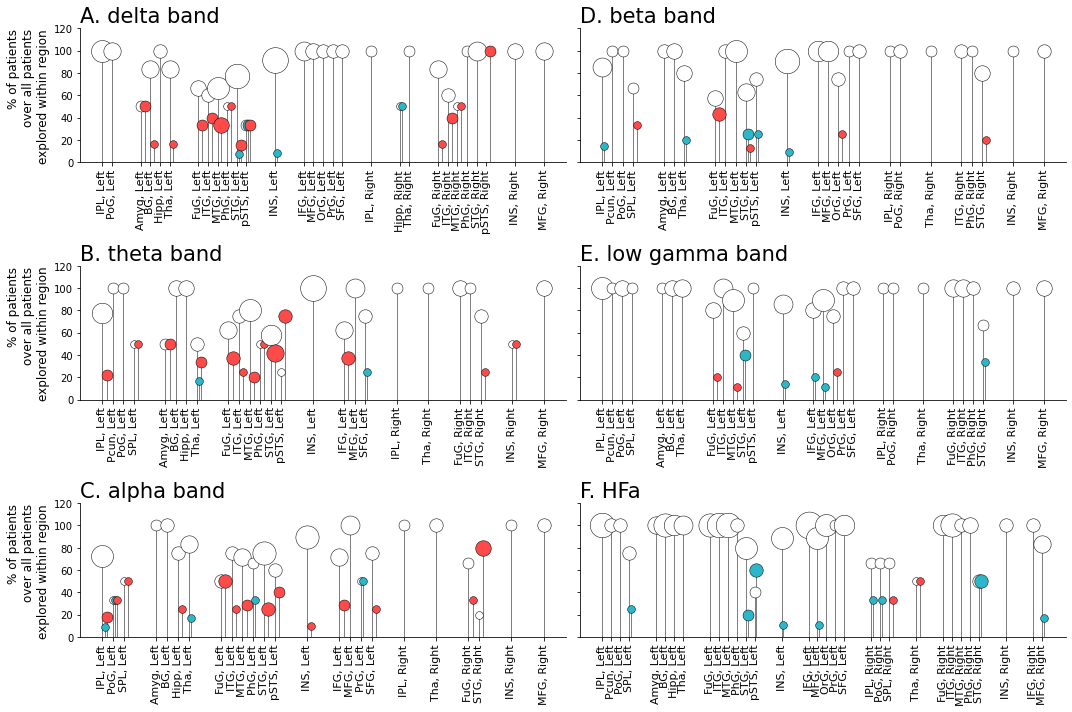

In [65]:
prevalence_figure(base=base, sign=sign)